# CIB Portfolio Process

In [13]:
import Quandl; import requests
import numpy as np; import pandas as pd
import math; import scipy
import scipy.stats; import matplotlib
import matplotlib.pyplot as plt; import matplotlib.pylab as pylab
import os; import random
import datetime; import seaborn as sns
prices_loaded = {}

%matplotlib inline  
pd.options.display.mpl_style = 'default'
pylab.rcParams['figure.figsize'] = 12, 6 

In [56]:
def get(ticker_list, kind = 'log_returns'):
    #takes in a ticker list and returns either a dataframe of closing price 'returns'
    #for each stock or closing 'prices'
    final_df = pd.DataFrame()
    price_loaded = {}
    for item in ticker_list:
        if item in prices_loaded:
            final_df[item] = prices_loaded[item]
            continue
        ticker = item
        temp_df = Quandl.get('YAHOO/'+str(ticker), 
                                         trim_start='2001-01-01', authtoken="H4uWGQ3jQdm96V7H2Abm")
        temp_df.index = pd.to_datetime(temp_df.index)
        temp_df = temp_df.sort()
        if (kind == 'prices'):
            add_series = temp_df.Close
        elif (kind == 'log_prices'):
            add_series = np.log(temp_df.Close);
        elif (kind == 'returns'):
            add_series = temp_df.Close.shift(-1) - temp_df.Close
        else:
            add_series = np.log(temp_df.Close).shift(-1) - np.log(temp_df.Close)
        price_loaded[item] = add_series   
        final_df[ticker] = add_series
        

    final_df = final_df.sort()
    final_df = final_df.dropna()
    return final_df


## Markowitz Efficient Portfolio Calculations

In [57]:
def portfolio_sharpe(return_df, weight_list):
    risk = float(portfolio_risk(return_df, weight_list))
    weight_t = np.matrix(weight_list)
    mean = np.matrix(return_df.mean()).transpose()
    sharpe = weight_t * mean / risk
    return float(sharpe)

def portfolio_e_return(return_df, weight_list):
    weight_t = np.matrix(weight_list)
    mean = np.matrix(return_df.mean()).transpose()
    return float(weight_t * mean)

def portfolio_risk(return_df, weight_list):
    #Take in a PRICE_DF with columns being each stock's daily log_returns
    #Take in WEIGHT_LIST with each list entry corresponding to the respective price_df
    #column's weight in the portfolio
    #PRICE_DF should be a concatenation of return series from return_series()
    if (abs(sum(weight_list) - 1) > .01):
        print("EROR: Weights do not sum to 1");
        return None
    cov_matrix = np.matrix(return_df.cov())
    weight_t = np.matrix(weight_list)
    weight = weight_t.transpose()
    variance = weight_t * cov_matrix * weight
    return float(variance)

In [58]:
def efficient_frontier_plot(portfolio, n_obs):
    count = 0
    xyw = pd.DataFrame([[None,None]])
    while count < n_obs:
        weight_list = [random.uniform(0, 1) for i in range(1, len(portfolio.columns) + 1)]
        
        weight_list = [item / float(sum(weight_list)) for item in weight_list]
        risk = portfolio_risk(portfolio, weight_list)
        e_return = portfolio_e_return(portfolio, weight_list)
        xyw = xyw.append([[math.sqrt(risk), e_return, weight_list]])
        
        count += 1
    xyw.columns = ['x', 'y', 'w']
    xyw['sharpe'] = xyw.y / xyw.x
    xyw['y'] = xyw.y * 100
    xyw.plot(title = "Efficient Frontier from " + str(n_obs) + 
             " Sample Portfolios", kind = 'scatter', y = 'y', x = 'x')
    plt.figure()
    plt.title("Histogram of Sample Sharpe Ratios\nMean: "+str(xyw.sharpe.mean()) + "\nSD: " + str(xyw.sharpe.std()))
    xyw.sharpe.hist(bins = 50)
    plt.figure()
    plt.title("Histogram of Sample Portfolio Variances\nMean: "+str(xyw.x.mean()) + "\nSD: " + str(xyw.x.std()))
    xyw.x.hist(bins = 50)
    plt.figure()
    plt.title("Histogram of Sample Portfolio Mean Returns\nMean: "+str((xyw.y / 100).mean()) + "\nSD: " + str((xyw.y / 100).std()))
    xyw.y.hist(bins = 50)
    return xyw

In [59]:
def find_tangency_portfolio(portfolio, n_obs):
    #finds tangency portfolio weights from n_obs number of samples
    temp = efficient_frontier_plot(portfolio, n_obs)
    return temp[temp.sharpe == temp.sharpe.max()].w[0]

def find_optimal_portfolios(portfolio, n_obs, quantile_start, quantile_end):
    #returns efficient frontier dataframe with only portfolio weights with 
    #a sharpe between the qth_start and qth_end quantile
    temp = efficient_frontier_plot(portfolio, n_obs)
    qth_start = find_quantile(temp.sharpe, quantile_start)
    qth_end = find_quantile(temp.sharpe, quantile_end)

    temp = temp[temp.sharpe < qth_end]
    temp = temp[temp.sharpe > qth_start]
    return temp



In [60]:
#a = find_tangency_portfolio(get(['AAPL', 'IBM', 'DE'], 'returns'), 1000)

,aapl
Date,
2015-10-26,-0.006353
2015-10-27,0.040378
2015-10-28,0.010509
2015-10-29,-0.008582
2015-10-30,0.013961


## Statistical Functions 

In [19]:
def find_quantile(series, qth_percentile):
    #returns the qth percentile element of the input series
    #qth percentile = 95 takes the 95% quantile
    return np.percentile(series, qth_percentile)

def qq_plot(return_series, distribution = 'norm'):
    scipy.stats.probplot(return_series, dist=distribution, plot=pylab, fit = True)

def histogram(series):
    series.hist()
    pylab.suptitle("Samples = " + str(len(series)) + 
               "\nMean = " + str(series.mean()) + 
               "\nSTD = " + str(series.std()))
    
    

In [20]:
def cov_heatmap(cov_df):
    sns.heatmap(cov_df)
    return

## Fundamental Analysis

In [52]:
def get_eps(ticker_list):
    final_df = pd.DataFrame()
    for ticker in ticker_list:
        try:
            temp_df = Quandl.get("SEC/" + ticker + "_EARNINGSPERSHAREDILUTED_Q", 
                                         authtoken="H4uWGQ3jQdm96V7H2Abm")
        except:
            print("WARNING: Could not find EPS for " + ticker)
            continue;
        temp_df.columns = [ticker]
        if not final_df.equals(pd.DataFrame()):
            final_df = pd.merge(final_df, temp_df, left_index = True, right_index = True,  how = 'outer')
        else:
            final_df = temp_df
    final_df = final_df.fillna(method = 'ffill')
    return final_df

In [53]:
def get_div(ticker_list):
    final_df = pd.DataFrame()
    for ticker in ticker_list:
        try:
            temp_df = Quandl.get(("SEC/DIV_" + ticker), 
                                         authtoken="H4uWGQ3jQdm96V7H2Abm")
        except:
            print("WARNING: Could not find DIV for " + ticker)
            continue;
        temp_df.columns = [ticker]
        if not final_df.equals(pd.DataFrame()):
            final_df = pd.merge(final_df, temp_df, left_index = True, right_index = True,  how = 'outer')
        else:
            final_df = temp_df
    final_df = final_df.fillna(method = 'ffill')    
    return final_df

In [22]:
def ally_df(ticker):
    #returns latest eps and dividend for each date
    #the first column is daily returns for the stock
    price_df = get([ticker])
    eps_df = get_eps([ticker])
    div_df = get_div([ticker])
    final_df = pd.merge(price_df, eps_df, right_index = True, left_index = True, how = 'left')
    final_df = pd.merge(final_df, div_df, right_index = True, left_index = True, how = 'left')
    final_df.columns = [ticker, 'EPS', 'DIV']
    final_df.EPS = final_df.EPS.fillna(method = 'ffill')
    final_df.DIV = final_df.DIV.fillna(method = 'ffill')
    return final_df

In [ ]:
def div_dis_model(ticker, discount_rate):
    temp = ally_df(ticker)


    temp = temp.fillna(0)
    temp['place'] = np.where(temp.DIV != temp.DIV.shift(1), 1, 0)

    temp['exp'] = temp.place.cumsum()
    temp['series_entry'] = np.where(temp.DIV != temp.DIV.shift(1), temp.DIV / (1 + discount_rate) ** (temp.exp), 0)
    answer = temp.series_entry.sum()
    return answer

## Get S&P 500 Tickers

In [23]:
def get_sp500():
    temp = pd.read_csv("data/sp500_tickers.csv")
    temp.columns = ['ticker', 'name', 'sector']
    temp = temp[temp.ticker != 'ICE']
    return temp


## >> CODE TESTING

In [24]:
#sp500 = get_sp500()
#sp500_p = get([a for a in sp500.ticker[sp500.sector == 'Energy']], 'log_returns')
port = get(['aapl', 'msft', 'ge', 'ba', 'de', 'f', 'coke', 'gs'])

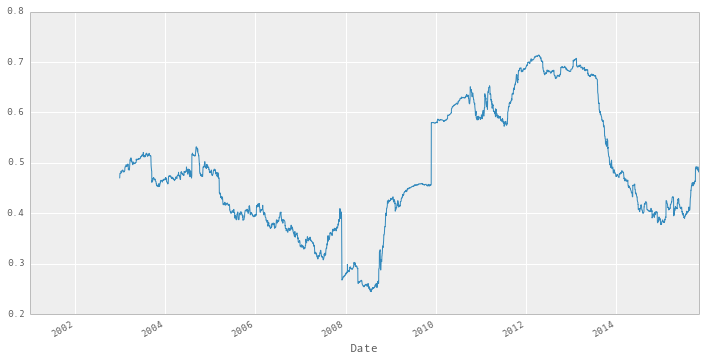

In [51]:
pd.rolling_corr(port['ge'], port['de'], window=500).plot()

In [12]:
def analyze_covariance(price_df, weight_list, reduced_size):
    cov_df = price_df.cov()
    p_risk = portfolio_risk(price_df, weight_list)
    
    
    

In [25]:
r = requests.get("http://instrumentmasterservice/instrumentmaster.json/v1/instrument/MSFT/price?from=2015-10-01&to=2015-10-29")

In [35]:
pd.read_json("http://instrumentmasterservice/instrumentmaster.json/v1/instrument/MSFT/price?from=2015-10-01&to=2015-10-29")

,changeFromLastClose,changeFromOpen,cummulativeCashDividend,cummulativeStockDividendRatio,currency,date,high,last,lastClose,low,open,percentChangeFromLastClose,percentChangeFromOpen,splitRatio,volume
0,0.29,0.440,0,1,USD,2015-10-28,53.980,53.98,53.98,52.860,53.540,0.5401,0.8218,1,47000753
1,-0.56,-0.300,0,1,USD,2015-10-27,54.370,53.69,53.69,53.580,53.990,-1.0323,-0.5557,1,50999907
2,1.38,1.720,0,1,USD,2015-10-26,54.320,54.25,54.25,52.500,52.530,2.6100,3.2740,1,64633324
3,4.84,0.570,0,1,USD,2015-10-23,54.070,52.87,52.87,52.250,52.300,10.0770,1.0900,1,135227059
4,0.83,0.500,0,1,USD,2015-10-22,48.950,48.03,48.03,47.090,47.530,1.7580,1.0520,1,56637074
5,-0.57,-0.720,0,1,USD,2015-10-21,47.990,47.20,47.20,47.110,47.920,-1.1930,-1.5030,1,25264710
6,0.15,0.330,0,1,USD,2015-10-20,47.810,47.77,47.77,47.020,47.440,0.3150,0.6960,1,30802235
7,0.11,0.200,0,1,USD,2015-10-19,47.880,47.62,47.62,47.020,47.420,0.2320,0.4220,1,29387581
8,0.50,0.490,0,1,USD,2015-10-16,47.540,47.51,47.51,46.897,47.020,1.0640,1.0420,1,26450334
9,0.33,0.000,0,1,USD,2015-10-15,47.030,47.01,47.01,46.530,47.010,0.7070,0.0000,1,27189370


In [63]:
temp = get(['AAPL', 'IBM', 'GE', 'BA'], 'log_returns')

In [73]:
#Get log returns dataframe
temp = get(['AAPL', 'IBM', 'GE', 'BA'], 'log_returns')
#Make mean return vector
mean = np.matrix(temp.mean()).transpose()
#Make weight vector
w = np.matrix([.4, .2, .1, .3])
#Make Covaraince matrix of returns
np.matrix(temp.cov())

matrix([[ 0.00172632,  0.00017263,  0.00019241,  0.00015067],
        [ 0.00017263,  0.00024332,  0.00016244,  0.00012195],
        [ 0.00019241,  0.00016244,  0.00038269,  0.00019067],
        [ 0.00015067,  0.00012195,  0.00019067,  0.00035773]])

In [44]:
a=get_sp500()
temp = [a for a in a.ticker]
temp = ally_df('IBM')


In [60]:
temp = ally_df('IBM')


temp = temp.fillna(0)
temp['place'] = np.where(temp.DIV != temp.DIV.shift(1), 1, 0)

temp['exp'] = temp.place.cumsum()
temp['series_entry'] = np.where(temp.DIV != temp.DIV.shift(1), temp.DIV / (1 + .05) ** (temp.exp), 0)
answer = temp.series_entry.sum()
answer

4.5705690082486017

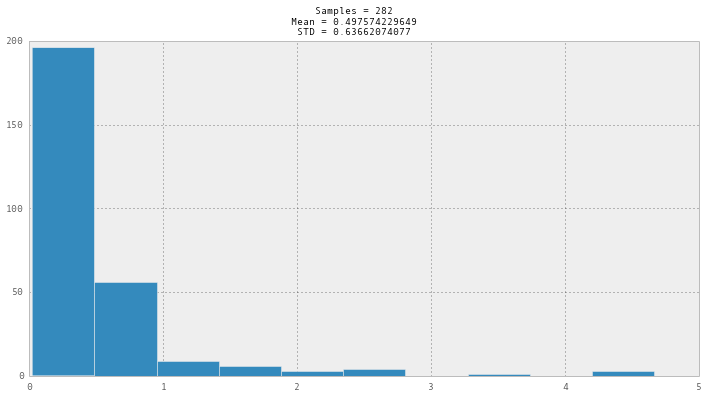

In [102]:
histogram(eps_df.std())

In [4]:
portfolio = get(['msft', 'mu', 'f', 'gs', 'ge', 'cvx', 'gs', 'ups', 'luv'], 'log_returns')

In [16]:
portfolio_sharpe(portfolio, [.2, .2, .4, .2])


-0.11761119743087618